# Creating a metabolic network from the Metacyc database

## Background

From the [EcoCyc database](http://ecocyc.org/PToolsWebsiteHowto.shtml#node_sec_8): 

Organization of the Cellular Overview: Within the cytoplasmic membrane, the small-molecule metabolism of the organism is depicted in several regions. **The glycolysis and the TCA cycle pathways, if present, will be placed in the middle of the diagram** to separate **predominately catabolic pathways on the right** from pathways of **anabolism and intermediary metabolism on the left**. The existence of anaplerotic pathways prevents rigid classification. The majority of pathways operate in the downward direction.

Here we will create a network representation of the Metacyc database. Nodes will be pathways and edges between nodes  are compounds linking the pathways. In order to emulate the Cellular Overview described above three networks will be generated, representing **Biosynthesis**, **Core** and **Degradation** pathways. These networks will then be composed together.

The resulting graph can be used to overlay pathway abundance data from sequencing experiments.

## Method

In [1]:
import networkx as nx, matplotlib.pyplot as plt, pandas as pd, pickle, matplotlib as mpl

from glob import glob
import plotly.plotly as py
from plotly.graph_objs import *
import numpy as np
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

%config InlineBackend.figure_format = 'svg'
%matplotlib inline
plt.style.use('ggplot')

### Read the metacyc data

Reads from the [parse-db](https://github.com/johnne/parse-db) repository.

In [2]:
metacyc_graph = pd.read_csv("https://github.com/johnne/parse-db/raw/master/metacyc/db_data/metacyc.pathway_graph.tab", header=0, sep="\t", index_col=0)
metacyc_df = pd.read_csv("https://github.com/johnne/parse-db/raw/master/metacyc/db_data/metacyc.ec2pathcats.tab", header=0, sep="\t", index_col=0)

### Make subsets of pathways

As seen in the Venn diagram below (based on Metacyc v. 20.1) there is some overlap in terms of categorization of pathways to higher levels in the hierarchy.

<p align="left">
    <img src="https://github.com/johnne/parse-db/raw/master/metacyc/images/metacyc_venn.png" width="300" height="300"/>
</p>

To make things easy for us, pathways that overlap in some way between the three different categories will first be put into the 'Core' (Generation of Precursor Metabolites and Energy) category, then the 'Degradation' (Degradation/Utilization/Assimilation).

In [3]:
core = ["Generation of Precursor Metabolites and Energy"]
syn = ["Biosynthesis"]
deg = ["Degradation/Utilization/Assimilation"]

core_pwys = list(set(metacyc_df.loc[metacyc_df.Category1.isin(core),"Pathway"]))
deg_pwys = list(set(metacyc_df.loc[metacyc_df.Category1.isin(deg),"Pathway"]))
deg_pwys = list(set(deg_pwys).difference(set(core_pwys)))
syn_pwys = list(set(metacyc_df.loc[metacyc_df.Category1.isin(syn),"Pathway"]))
syn_pwys = list(set(syn_pwys).difference(set(core_pwys+deg_pwys)))

Create three separate dataframes with no edges between the three subgraphs. Those edges will be added later.

In [4]:
core_graph_df = metacyc_graph.loc[(metacyc_graph.Node1.isin(core_pwys)) & ((metacyc_graph.Node2.isin(core_pwys)))]
core_pwy_singles = list(set(core_pwys).difference(set(core_graph_df.Node1)))
syn_graph_df = metacyc_graph.loc[(metacyc_graph.Node1.isin(syn_pwys)) & ((metacyc_graph.Node2.isin(syn_pwys)))]
syn_pwy_singles = list(set(syn_pwys).difference(set(syn_graph_df.Node1)))
deg_graph_df = metacyc_graph.loc[(metacyc_graph.Node1.isin(deg_pwys)) & ((metacyc_graph.Node2.isin(deg_pwys)))]
deg_pwy_singles = list(set(deg_pwys).difference(set(deg_graph_df.Node1)))

Count number of edges (connections) for each pathway.

In [5]:
## Count edges for pathways
edge_counts = metacyc_graph.groupby("Node1").count().ix[:,0]
edge_counts = edge_counts.sort_values(ascending=False)

### Create the graphs

#### Functions to order nodes and assign node attributes

In [6]:
def make_shells(num_shells,nodes):
    '''Divides nodes into shells starting from most connected nodes in the center'''
    total_nodes = len(nodes)
    shells = [[]]*num_shells
    ## If all shells had the same radius, they would have nodes_per_shell nodes
    nodes_per_shell = np.round(total_nodes/num_shells) 
    added_nodes = 0
    for i,s in enumerate(shells,start=1):
        this_shell = nodes_per_shell
        ## The shell receives from_inner nodes from the inner shell
        if i==1: from_inner = 0
        #else: from_inner = np.round(nodes_per_shell-(nodes_per_shell*((i-1)/i)))
        else: from_inner = np.round(nodes_per_shell*((i-1)/float(i)))
        ## The shell gives to_outer nodes to the outer shell
        to_outer = np.round(nodes_per_shell*(float(i)/(i+1)))
        ## Calculate the resulting number of nodes to store for this shell
        num_nodes = int(from_inner+this_shell-to_outer)
        
        ## The last shell receive the remaining nodes
        if i==num_shells: shells[i-1] = nodes
        else: 
            shells[i-1] = nodes[:num_nodes]
            nodes = nodes[num_nodes:]
    return shells

def assign_node_weights(g,d):
    '''Assign node linkage counts as attributes'''
    for n in g.nodes():
        try: w = d[n]
        except KeyError: w = 0
        try: g.node[n]['weight'] = w
        except KeyError: g.node[n] = {'weight': w}
    return g

def assign_node_pos(g,pos):
    for n in g.nodes(): g.node[n]['pos'] = pos[n]
    return g

def create_shell_graph(g,nodes,r,numshells,x,y):
    g_shells = make_shells(numshells,nodes)
    g_layout = nx.shell_layout(g, nlist=g_shells, center=(x,y), scale=r)
    g = assign_node_pos(g,g_layout)
    return g

def add_intergraph_edges(g,p1,p2,df):
    for i in df.loc[(df.Node1.isin(p1)) & (df.Node2.isin(p2))].index:
        e = tuple(df.loc[i,["Node1","Node2"]])
        cpd = str(df.loc[i,"CPD"])
        g.add_edge(*e)
        g.edge[e[0]][e[1]]['CPD'] = cpd
    return g

Initialize the three graphs from the pandas dataframes

In [7]:
core_graph = nx.from_pandas_dataframe(core_graph_df, source="Node1",target="Node2",edge_attr="CPD")
deg_graph = nx.from_pandas_dataframe(deg_graph_df, source="Node1",target="Node2",edge_attr="CPD")
syn_graph = nx.from_pandas_dataframe(syn_graph_df, source="Node1",target="Node2",edge_attr="CPD")

## Add single nodes to the graphs
syn_graph.add_nodes_from(syn_pwy_singles)
core_graph.add_nodes_from(core_pwy_singles)
deg_graph.add_nodes_from(deg_pwy_singles)

Create shell layouts for each subgraph. Sort pathways by number of connections so that the most highly connected ('central', e.g. [Glycolysis](http://metacyc.org/META/NEW-IMAGE?type=PATHWAY&object=GLYCOLYSIS)) pathways will be in the middle of each subgraph. The 'Core' subgraph contains 3 shells with a radius of 1 for the outermost shell while the 'Biosynthesis' and 'Degradation' graphs contain 6 shells each, with a radius of 2.

The subgraphs are positioned similar to the EcoCyc cellular overview, with Biosynthesis pathways to the left (x=-3,y=0), Core pathways in the middle (x=0,y=1) and Degradation pathways to the right (x=3,y=0).

*Each shell will have a number of pathways (roughly) proportional to the size of the shell.*

In [8]:
## BIOSYNTHESIS
nodes = set(syn_pwys+syn_pwy_singles)
nodes = list(edge_counts.loc[nodes].sort_values(ascending=False).fillna(0).index)
syn_graph = create_shell_graph(syn_graph,nodes,r=2,numshells=6,x=-3,y=0)

## CORE
nodes = list(set(core_pwys+core_pwy_singles))
nodes = list(edge_counts.loc[nodes].sort_values(ascending=False).fillna(0).index)
core_graph = create_shell_graph(core_graph,nodes,r=1,numshells=3,x=0,y=1)

## DEGRADATION
nodes = set(deg_pwys+deg_pwy_singles)
nodes = list(edge_counts.loc[nodes].sort_values(ascending=False).fillna(0).index)
deg_graph = create_shell_graph(deg_graph,nodes,r=2,numshells=6,x=3,y=0)

#### Final touches

Here the subgraphs are composed together and node the number of connections added as 'node weights'. Finally, edges are added connecting pathways between subgraphs.

In [9]:
## Compose all three graphs into one
G = nx.compose_all([core_graph,syn_graph,deg_graph])

## Assign node weights
G = assign_node_weights(G,edge_counts)

## Add final edges between the three subgraphs
G = add_intergraph_edges(G,core_pwys,syn_pwys,metacyc_graph) ## Between biosynthesis and core
G = add_intergraph_edges(G,core_pwys,deg_pwys,metacyc_graph) ## Between degradation and core
G = add_intergraph_edges(G,syn_pwys,deg_pwys,metacyc_graph) ## Between degradation and biosynthesis

## Visualize the resulting graph

### Using matplotlib

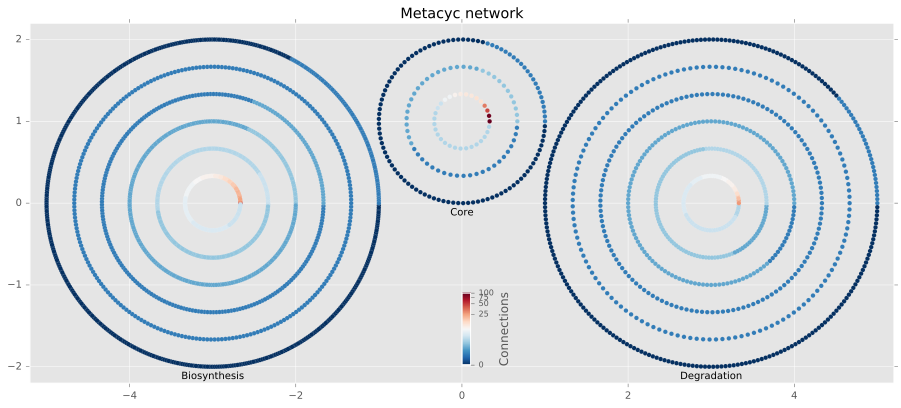

In [10]:
def plot_graph(G,df,f):
    ## Add values for node colors and edge widths
    node_colors = []
    edge_widths = []
    ## Use log values for weights to get better distribution of colors
    for node in G.nodes(): node_colors.append(np.log(G.node[node]['weight']+1))
    for edge in G.edges():
        p1,p2 = edge
        w1 = G.node[p1]['weight']
        w2 = G.node[p2]['weight']
        ## Only show edges for nodes with >=10 connections
        if w1>10 or w2>10: edge_widths.append(0.1)
        else: edge_widths.append(0)

    ## Create figure and first axis
    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_axes([0, 0, 1, 1])
    nx.draw_networkx(G,pos=nx.get_node_attributes(G,"pos"),node_size=20,node_color=node_colors,
                 cmap="RdBu_r",width=0.05, with_labels=False, linewidths=0.1,ax=ax1)
    ## Plot title for the plot
    ax1.set_title("Metacyc network")
    ## Plot subgraph labels
    ax1.text(x=0,y=-0.15,s="Core",horizontalalignment='center')
    ax1.text(x=-3,y=-2.15,s="Biosynthesis",horizontalalignment='center')
    ax1.text(x=3,y=-2.15,s="Degradation",horizontalalignment='center')
    ## Set limits of axes
    ax1.set_xlim(-5.2,5.2)
    ax1.set_ylim(-2.2,2.2)

    ## Add colorbar
    tickvals = np.log([1,26,51,76,101])
    ticktext = ["0","25","50","75","100"]
    ax2 = fig.add_axes([0.5, 0.05, 0.01,0.2])
    cmap = mpl.cm.RdBu_r
    norm = mpl.colors.Normalize(vmin=np.log(1), vmax=np.log(101))
    cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=norm,ticks=tickvals,orientation='vertical')
    cb.set_ticklabels(ticktext)
    cb.set_label("Connections", )
    for item in ax2.get_yticklabels(): item.set_fontsize(8)
    plt.savefig(f,dpi=300, bbox_inches="tight")

mpl_file_box = widgets.Text(value="images/metacyc_network_mpl.png", description="Filename")
interact(plot_graph, G=fixed(G), df=fixed(metacyc_df), f=mpl_file_box, __manual=True)

### Using plotly

In [11]:
def plotly_graph(G, df, f):
    ## Add colorbar for nodes, using log scale
    ## Use log scale for colorbar
    tickvals = np.log([1,26,51,76,101])
    ticktext = ["0","25","50","75","100"]
    node_colorbar=dict(thickness=15,len=0.5,title='Connections',xanchor='left',
                       titleside='right',tickmode='array',ticktext=ticktext, tickvals=tickvals)    

    ## Add edge and node traces
    edge_trace = Scatter(x=[],y=[],text=[],line=Line(width=0.1,color='#888'),hoverinfo='text',mode='lines')
    node_trace = Scatter(x=[],y=[],text=[],mode='markers',hoverinfo='text',marker=Marker(showscale=True,colorscale='RdBu',
        reversescale=False,color=[],size=6,colorbar=node_colorbar,line=dict(width=0.5)))

    ## Create figure layout
    fig_layout = Layout(title="Metacyc network",titlefont=dict(size=12),showlegend=False,width=1200,height=500,
                hovermode='closest',margin=dict(b=20,l=5,r=5,t=20),
                annotations=[dict(showarrow=False,text="Biosynthesis",x=-3, y=-2.15),
                            dict(showarrow=False,text="Core metabolism",x=0, y=-0.15),
                            dict(showarrow=False,text="Degradation",x=3, y=-2.15),
                            dict(showarrow=False,x=0,y=-2.5,
                                 text="Jupyter notebook on GitHub: <a href='https://github.com/johnne/biovisualize/blob/master/metacyc/create_metacyc_network.ipynb'> create_metacyc_network.ipynb</a>")],
                xaxis=XAxis(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=YAxis(showgrid=False, zeroline=False, showticklabels=False))

    ## Add edges to edge trace
    for edge in G.edges():
        x0, y0 = G.node[edge[0]]['pos']
        x1, y1 = G.node[edge[1]]['pos']
        edge_trace['x'] += [x0, x1, None]
        edge_trace['y'] += [y0, y1, None]

    ## Add nodes to node trace
    for n in G.nodes():
        x, y = G.node[n]['pos']
        node_trace['x'].append(x)
        node_trace['y'].append(y)
        node_trace['marker']['color'].append(np.log(G.node[n]['weight']+1))
        node_info = list(set(df.loc[df.Pathway==n,"Name"]))[0]+" (#"+str(G.node[n]['weight'])+")"
        node_trace['text'].append(node_info)

    fig = Figure(data=Data([edge_trace, node_trace]), layout=fig_layout)
    return py.iplot(fig, filename=f, fileopt='overwrite')
plotly_file_box = widgets.Text(value="metacyc_network", description="Filename")
interact(plotly_graph,G=fixed(G),df=fixed(metacyc_df), f=plotly_file_box, __manual=True)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


<function __main__.plotly_graph>

### Saving the graph to file

The graph 'G' is saved in [pickle format](https://docs.python.org/3/library/pickle.html), a serialized byte stream of a Python object. This format will preserve Python objects used as nodes or edges.

In [12]:
nx.write_gpickle(G, "datadir/metacyc_shell_network.gpickle")

To read the graph from file simply run: nx.read_gpickle("datadir/metacyc_shell_network.gpickle")